In [1]:
import allel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import zarr
import dask
import seaborn as sns
import sys
import malariagen_data
import collections
import random
import os
import functools
#import petlx
#import petl as etl
nnz = np.count_nonzero
ag3 = malariagen_data.Ag3("gs://vo_agam_release/")

In [2]:
# quieten dask warnings about large chunks
dask.config.set(**{'array.slicing.split_large_chunks': True})

In [3]:
def log(*msg):
    print(' '.join(map(str, msg)), file=sys.stdout)
    sys.stdout.flush()

In [4]:
def subplots(*args, despine=None, **kwargs):
    fig, ax = plt.subplots(*args, **kwargs)
    if despine is None:
        despine = dict(offset=10, trim=False)
    if hasattr(ax, '__len__'):
        for a in ax:
            sns.despine(ax=a, **despine)
    else:
        sns.despine(ax=ax, **despine)
    return fig, ax

In [13]:
df_samples = pd.read_excel("/mnt/c/Users/rando/Documenti/Ag1000G/Data/Meta/meta_new_3_0.xlsx", sheet_name=0)
ac_count = zarr.open('/mnt/c/Users/rando/Documenti/Ag1000G/Data/Extras/fw_biallelic_count_pca_pops.zarr/')

In [14]:
samples = list(df_samples['sample_id'])
samples = [str(s) for s in samples]
contigs = ['2R','2L', '3L','3R','X']

In [15]:
def select_populations(pop1, pop2, species_pop2):
    pop1 = tbl_samples.select(lambda r: r.population == pop1 and r.population == pop1).values('sample_id').list()
    pop2 = tbl_samples.select(lambda r: r.country == pop2 and r.species == species_pop2).values('sample_id').list()
    index_pop1 = [samples.index(i) for i in pop1]
    index_pop2 = [samples.index(i) for i in pop1]
    return index_pop1, index_pop2

In [16]:
def genotype_populations(pop1, pop2, chrom, species_pop2):
    ga = {chrom: ag3.snp_genotypes(chrom, site_mask="gamb_colu", sample_sets=["AG1000G-BF-A", "AG1000G-BF-B", "AG1000G-BF-C", "AG1000G-CI", "AG1000G-GH", "AG1000G-GM-A", "AG1000G-GM-B", 
                                       "AG1000G-GM-C", "AG1000G-GN-A", "AG1000G-GN-B", "AG1000G-ML-A", "AG1000G-ML-B", "AG1000G-GW"]) for chrom in contigs}
    pop1, pop2 = select_populations(pop1, pop2, species_pop2)
    g_pop1 = {chrom: allel.GenotypeDaskArray(ga[chrom]).take(pop1, axis=1) for chrom in contigs}
    random_index = random.sample(pop2, len(pop1))
    g_pop2 = {chrom: allel.GenotypeDaskArray(ga[chrom]).take(pop2, axis=1) for chrom in contigs}
    return g_pop1, g_pop2

In [17]:
def ac_count_populations (chrom, pop1, pop2):
    ac_pop1 = allel.AlleleCountsChunkedArray(ac_count[chrom][pop1])
    ac_col = allel.AlleleCountsChunkedArray(ac_count[chrom]['An.col'][:])
    ac_gam = allel.AlleleCountsChunkedArray(ac_count[chrom]['An.gam'][:])

    if (pop2 == "An.col"):
        ac_pop2 = ac_col
    else:
        if (pop2 == 'An.gam'):
            ac_pop2 = ac_gam
    return ac_pop1, ac_pop2

In [18]:
def plot_pair_fst(pop1, pop2, chrom, start, stop, size):
    # load allele counts for region
    pos = ag3.snp_sites(region=chrom, field='POS', site_mask="gamb_colu")
    pos = allel.SortedIndex(pos.compute())
    loc = pos.locate_range(start, stop)
    ac1, ac2 =  ac_count_populations(chrom, pop1, pop2)
    ac1 = ac1[loc]
    ac2 = ac2[loc] 
    pos=pos[loc]
    # ascertain SNPs
    loc_asc = ac1.is_segregating() & ac2.is_segregating() & (ac1.max_allele() <= 1) & (ac2.max_allele() <= 1)
    log('ascertainment', pop1, pop2, chrom, start, stop, nnz(loc_asc))
    ac1 = ac1[loc_asc]
    ac2 = ac2[loc_asc]
    pos = pos[loc_asc]
    
    # compute Fst
    fst, windows, counts = allel.windowed_hudson_fst(pos,ac1, ac2, size)
    x = np.asarray(windows).mean(axis=1)
    #x = allel.moving_statistic(pos, np.median, size=size)
    return fst,x

## Fst GA-CO 100Kbp

In [14]:
a_coga = plot_pair_fst('An.col', 'An.gam', '2R', start=1, stop=None, size=100000)
b_coga = plot_pair_fst('An.col', 'An.gam', '2L', start=1, stop=None, size=100000)
c_coga = plot_pair_fst('An.col', 'An.gam', '3R', start=1, stop=None, size=100000)
d_coga = plot_pair_fst('An.col', 'An.gam', '3L', start=1, stop=None, size=100000)
e_coga = plot_pair_fst('An.col', 'An.gam', 'X', start=1, stop=None, size=100000)

ascertainment An.col An.gam 2R 1 None 2019508
ascertainment An.col An.gam 2L 1 None 2319050
ascertainment An.col An.gam 3R 1 None 2589917
ascertainment An.col An.gam 3L 1 None 1886088
ascertainment An.col An.gam X 1 None 845165


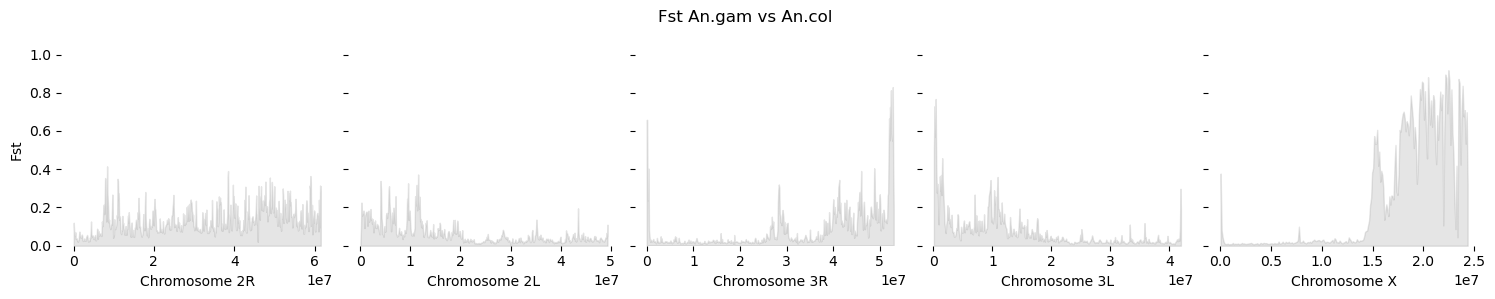

In [16]:
fig, ((ax1, ax2, ax3, ax4, ax5)) = plt.subplots(1, 5, figsize=(15, 3))
fig.suptitle("Fst An.gam vs An.col")

# Remove spines
for ax in [ax1, ax2, ax3, ax4, ax5]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

#ax1.plot(a_gcx1co_100[1], a_gcx1co_100[0], lw=0.8)
ax1.fill_between(a_coga[1], 0, a_coga[0], color='grey', alpha=0.2)  # Add fill_between
ax1.set_ylabel("Fst")
ax1.set_xlabel('Chromosome 2R')
ax1.set_ylim(0, 1)

#ax2.plot(b_gcx1co_100[1], b_gcx1co_100[0], lw=0.8)
ax2.fill_between(b_coga[1], 0, b_coga[0], color='grey', alpha=0.2)  # Add fill_between
ax2.set_xlabel('Chromosome 2L')
ax2.set_ylim(0, 1)

#ax3.plot(c_gcx1co_100[1], c_gcx1co_100[0], lw=0.8)
ax3.fill_between(c_coga[1], 0, c_coga[0], color='grey', alpha=0.2)  # Add fill_between
ax3.set_xlabel('Chromosome 3R')
ax3.set_ylim(0, 1)

#ax4.plot(d_gcx1co_100[1], d_gcx1co_100[0], lw=0.8)
ax4.fill_between(d_coga[1], 0, d_coga[0], color='grey', alpha=0.2)  # Add fill_between
ax4.set_xlabel('Chromosome 3L')
ax4.set_ylim(0, 1)

#ax5.plot(e_gcx1co_100[1], e_gcx1co_100[0], lw=0.8)
ax5.fill_between(e_coga[1], 0, e_coga[0], color='grey', alpha=0.2)  # Add fill_between
ax5.set_xlabel('Chromosome X')
ax5.set_ylim(0, 1)

for ax in fig.get_axes():
    ax.label_outer()

plt.tight_layout()
plt.show()


## Fst gcx1-GM - GA 100Kbp

In [17]:
a_gcx1ga_100 = plot_pair_fst('GM-2', 'An.gam', '2R', start=1, stop=None, size=100000)
b_gcx1ga_100 = plot_pair_fst('GM-2', 'An.gam', '2L', start=1, stop=None, size=100000)
c_gcx1ga_100 = plot_pair_fst('GM-2', 'An.gam', '3R', start=1, stop=None, size=100000)
d_gcx1ga_100 = plot_pair_fst('GM-2', 'An.gam', '3L', start=1, stop=None, size=100000)
e_gcx1ga_100 = plot_pair_fst('GM-2', 'An.gam', 'X', start=1, stop=None, size=100000)

ascertainment GM-2 An.gam 2R 1 None 1233693
ascertainment GM-2 An.gam 2L 1 None 1304557
ascertainment GM-2 An.gam 3R 1 None 1566740
ascertainment GM-2 An.gam 3L 1 None 1124689
ascertainment GM-2 An.gam X 1 None 436673


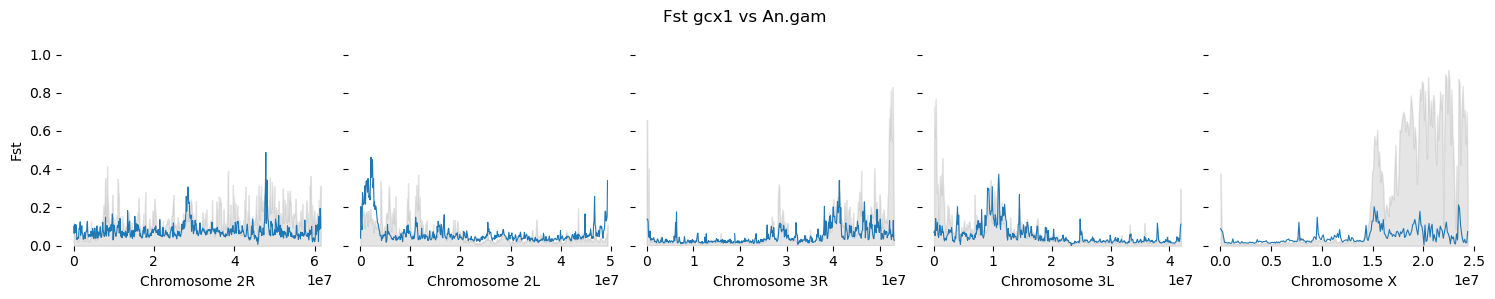

In [18]:
fig, ((ax1, ax2, ax3, ax4, ax5)) = plt.subplots(1, 5, figsize=(15, 3))
fig.suptitle("Fst gcx1 vs An.gam")

# Remove spines
for ax in [ax1, ax2, ax3, ax4, ax5]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

ax1.plot(a_gcx1ga_100[1], a_gcx1ga_100[0], lw=0.8)
ax1.fill_between(a_coga[1], 0, a_coga[0], color='grey', alpha=0.2)  # Add fill_between
ax1.set_ylabel("Fst")
ax1.set_xlabel('Chromosome 2R')
ax1.set_ylim(0, 1)

ax2.plot(b_gcx1ga_100[1], b_gcx1ga_100[0], lw=0.8)
ax2.fill_between(b_coga[1], 0, b_coga[0], color='grey', alpha=0.2)  # Add fill_between
ax2.set_xlabel('Chromosome 2L')
ax2.set_ylim(0, 1)

ax3.plot(c_gcx1ga_100[1], c_gcx1ga_100[0], lw=0.8)
ax3.fill_between(c_coga[1], 0, c_coga[0], color='grey', alpha=0.2)  # Add fill_between
ax3.set_xlabel('Chromosome 3R')
ax3.set_ylim(0, 1)

ax4.plot(d_gcx1ga_100[1], d_gcx1ga_100[0], lw=0.8)
ax4.fill_between(d_coga[1], 0, d_coga[0], color='grey', alpha=0.2)  # Add fill_between
ax4.set_xlabel('Chromosome 3L')
ax4.set_ylim(0, 1)

ax5.plot(e_gcx1ga_100[1], e_gcx1ga_100[0], lw=0.8)
ax5.fill_between(e_coga[1], 0, e_coga[0], color='grey', alpha=0.2)  # Add fill_between
ax5.set_xlabel('Chromosome X')
ax5.set_ylim(0, 1)

for ax in fig.get_axes():
    ax.label_outer()

plt.tight_layout()
plt.show()


## Fst gcx1-GM - GA 1bp

In [19]:
#a_gcx1ga = plot_pair_fst('GM-2', 'An.gam', '2R', start=1, stop=None, size=1)
#b_gcx1ga = plot_pair_fst('GM-2', 'An.gam', '2L', start=1, stop=None, size=1)
#c_gcx1ga = plot_pair_fst('GM-2', 'An.gam', '3R', start=1, stop=None, size=1)
#d_gcx1ga = plot_pair_fst('GM-2', 'An.gam', '3L', start=1, stop=None, size=1)
#e_gcx1ga = plot_pair_fst('GM-2', 'An.gam', 'X', start=1, stop=None, size=1)
#np.savez('a_gcx1ga.npz', data=a_gcx1ga)
#np.savez('b_gcx1ga.npz', data=b_gcx1ga)
#np.savez('c_gcx1ga.npz', data=c_gcx1ga)
#np.savez('d_gcx1ga.npz', data=d_gcx1ga)
#np.savez('e_gcx1ga.npz', data=e_gcx1ga)

In [16]:
with np.load('a_gcx1ga.npz') as data:
    a_gcx1ga = dask.array.from_array(data['data'])

In [17]:
with np.load('b_gcx1ga.npz') as data:
    b_gcx1ga = dask.array.from_array(data['data'])

In [18]:
with np.load('c_gcx1ga.npz') as data:
    c_gcx1ga = dask.array.from_array(data['data'])

In [19]:
with np.load('d_gcx1ga.npz') as data:
    d_gcx1ga = dask.array.from_array(data['data'])

In [20]:
with np.load('e_gcx1ga.npz') as data:
    e_gcx1ga = dask.array.from_array(data['data'])

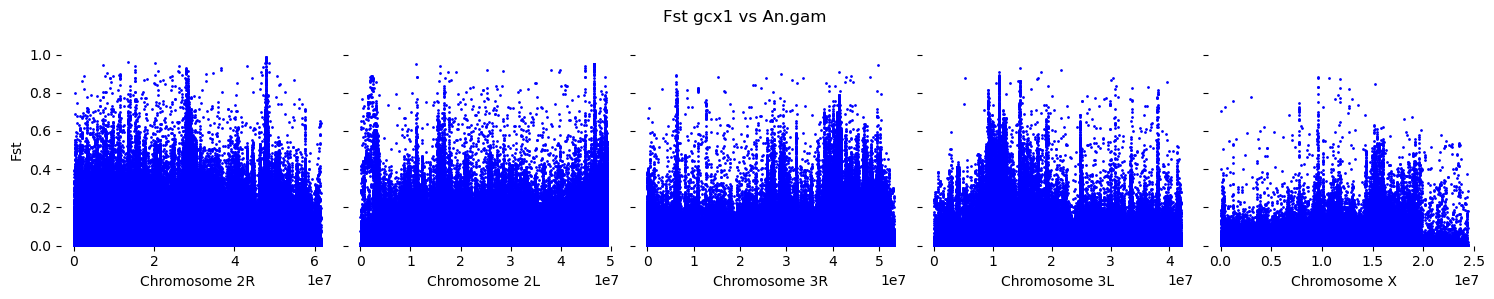

In [25]:
import matplotlib.pyplot as plt

fig, ((ax1, ax2, ax3, ax4, ax5)) = plt.subplots(1, 5, figsize=(15, 3))
fig.suptitle("Fst gcx1 vs An.gam")

# Remove spines
for ax in [ax1, ax2, ax3, ax4, ax5]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)


ax1.plot(a_gcx1ga[1], a_gcx1ga[0], 'bo', markersize=1)
ax1.set_ylabel("Fst")
ax1.set_xlabel('Chromosome 2R')
ax1.set_ylim(0, 1)

ax2.plot(b_gcx1ga[1], b_gcx1ga[0], 'bo', markersize=1)
ax2.set_xlabel('Chromosome 2L')
ax2.set_ylim(0, 1)

ax3.plot(c_gcx1ga[1], c_gcx1ga[0], 'bo', markersize=1)
ax3.set_xlabel('Chromosome 3R')
ax3.set_ylim(0, 1)

ax4.plot(d_gcx1ga[1], d_gcx1ga[0], 'bo', markersize=1)
ax4.set_xlabel('Chromosome 3L')
ax4.set_ylim(0, 1)

ax5.plot(e_gcx1ga[1], e_gcx1ga[0], 'bo', markersize=1)
ax5.set_xlabel('Chromosome X')
ax5.set_ylim(0, 1)

for ax in fig.get_axes():
    ax.label_outer()

plt.tight_layout()
plt.show()

/tmp/ipykernel_3654/637413109.py:21: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  ax.plot(filtered_x, filtered_y, 'bo', markersize=1, label='> 0.4', color='orange')
/tmp/ipykernel_3654/637413109.py:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  ax.plot(filtered_x_09, filtered_y_09, 'bo', markersize=1, label='> 0.8', color='red')


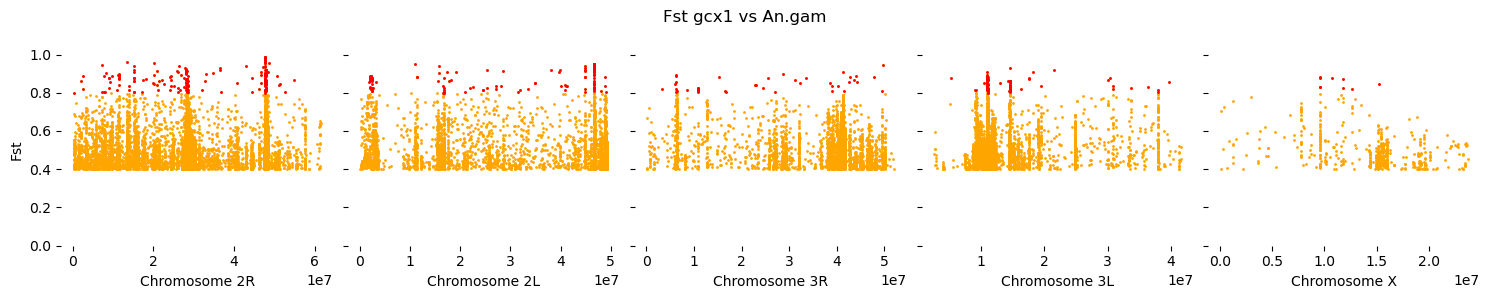

In [26]:
import matplotlib.pyplot as plt

fig, ((ax1, ax2, ax3, ax4, ax5)) = plt.subplots(1, 5, figsize=(15, 3))
fig.suptitle("Fst gcx1 vs An.gam")

# Remove spines
for ax in [ax1, ax2, ax3, ax4, ax5]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

# Filtering and plotting for each subplot
for ax, data, label in zip([ax1, ax2, ax3, ax4, ax5], 
                           [a_gcx1ga, b_gcx1ga, c_gcx1ga, d_gcx1ga, e_gcx1ga], 
                           ['Chromosome 2R', 'Chromosome 2L', 'Chromosome 3R', 'Chromosome 3L', 'Chromosome X']):
    filtered_indices = data[0].compute() > 0.4
    filtered_x = data[1][filtered_indices]
    filtered_y = data[0][filtered_indices]
    
    ax.plot(filtered_x, filtered_y, 'bo', markersize=1, label='> 0.4', color='orange')

    filtered_indices_09 = data[0].compute() > 0.8
    filtered_x_09 = data[1][filtered_indices_09]
    filtered_y_09 = data[0][filtered_indices_09]

    ax.plot(filtered_x_09, filtered_y_09, 'bo', markersize=1, label='> 0.8', color='red')
    
    ax.set_xlabel(label)
    ax.set_ylabel("Fst")
    ax.set_ylim(0, 1)

for ax in fig.get_axes():
    ax.label_outer()

plt.tight_layout()
plt.show()


--------------------------
## Fst gcx1-GM - CO 100 kbp

In [27]:
a_gcx1co_100 = plot_pair_fst('GM-2', 'An.col', '2R', start=1, stop=None, size=100000)
b_gcx1co_100 = plot_pair_fst('GM-2', 'An.col', '2L', start=1, stop=None, size=100000)
c_gcx1co_100 = plot_pair_fst('GM-2', 'An.col', '3R', start=1, stop=None, size=100000)
d_gcx1co_100 = plot_pair_fst('GM-2', 'An.col', '3L', start=1, stop=None, size=100000)
e_gcx1co_100 = plot_pair_fst('GM-2', 'An.col', 'X', start=1, stop=None, size=100000)

ascertainment GM-2 An.col 2R 1 None 1035150
ascertainment GM-2 An.col 2L 1 None 1206815
ascertainment GM-2 An.col 3R 1 None 1488326
ascertainment GM-2 An.col 3L 1 None 1077391
ascertainment GM-2 An.col X 1 None 391329


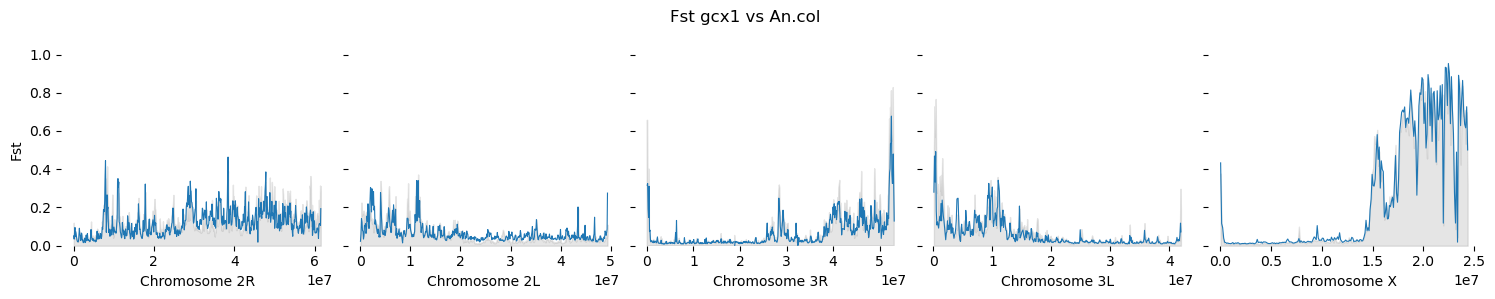

In [28]:
import matplotlib.pyplot as plt

fig, ((ax1, ax2, ax3, ax4, ax5)) = plt.subplots(1, 5, figsize=(15, 3))
fig.suptitle("Fst gcx1 vs An.col")

# Remove spines
for ax in [ax1, ax2, ax3, ax4, ax5]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

ax1.plot(a_gcx1co_100[1], a_gcx1co_100[0], lw=0.8)
ax1.fill_between(a_coga[1], 0, a_coga[0], color='grey', alpha=0.2)  # Add fill_between
ax1.set_ylabel("Fst")
ax1.set_xlabel('Chromosome 2R')
ax1.set_ylim(0, 1)

ax2.plot(b_gcx1co_100[1], b_gcx1co_100[0], lw=0.8)
ax2.fill_between(b_coga[1], 0, b_coga[0], color='grey', alpha=0.2)  # Add fill_between
ax2.set_xlabel('Chromosome 2L')
ax2.set_ylim(0, 1)

ax3.plot(c_gcx1co_100[1], c_gcx1co_100[0], lw=0.8)
ax3.fill_between(c_coga[1], 0, c_coga[0], color='grey', alpha=0.2)  # Add fill_between
ax3.set_xlabel('Chromosome 3R')
ax3.set_ylim(0, 1)

ax4.plot(d_gcx1co_100[1], d_gcx1co_100[0], lw=0.8)
ax4.fill_between(d_coga[1], 0, d_coga[0], color='grey', alpha=0.2)  # Add fill_between
ax4.set_xlabel('Chromosome 3L')
ax4.set_ylim(0, 1)

ax5.plot(e_gcx1co_100[1], e_gcx1co_100[0], lw=0.8)
ax5.fill_between(e_coga[1], 0, e_coga[0], color='grey', alpha=0.2)  # Add fill_between
ax5.set_xlabel('Chromosome X')
ax5.set_ylim(0, 1)

for ax in fig.get_axes():
    ax.label_outer()

plt.tight_layout()
plt.show()


## Fst gcx1-GM - CO 1bp

In [1]:
#a_gcx1co = plot_pair_fst('GM-2', 'An.col', '2R', start=1, stop=None, size=1)
#b_gcx1co = plot_pair_fst('GM-2', 'An.col', '2L', start=1, stop=None, size=1)
#c_gcx1co = plot_pair_fst('GM-2', 'An.col', '3R', start=1, stop=None, size=1)
#d_gcx1co = plot_pair_fst('GM-2', 'An.col', '3L', start=1, stop=None, size=1)
#e_gcx1co = plot_pair_fst('GM-2', 'An.col', 'X', start=1, stop=None, size=1)
#np.savez('a_gcx1co.npz', data=a_gcx1co)
#np.savez('b_gcx1co.npz', data=b_gcx1co)
#np.savez('c_gcx1co.npz', data=c_gcx1co)
#np.savez('d_gcx1co.npz', data=d_gcx1co)
#np.savez('e_gcx1co.npz', data=e_gcx1co)

In [11]:
with np.load('a_gcx1co.npz') as data:
    a_gcx1co = dask.array.from_array(data['data'])

In [12]:
with np.load('b_gcx1co.npz') as data:
    b_gcx1co = dask.array.from_array(data['data'])

In [13]:
with np.load('c_gcx1co.npz') as data:
    c_gcx1co = dask.array.from_array(data['data'])

In [14]:
with np.load('d_gcx1co.npz') as data:
    d_gcx1co = dask.array.from_array(data['data'])

In [15]:
with np.load('e_gcx1co.npz') as data:
    e_gcx1co = dask.array.from_array(data['data'])

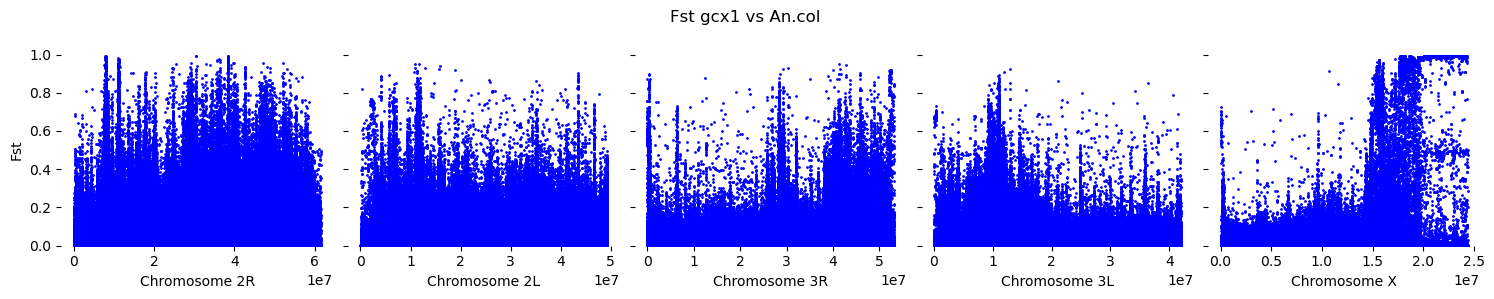

In [17]:
fig, ((ax1, ax2, ax3, ax4, ax5)) = plt.subplots(1, 5, figsize=(15, 3))
fig.suptitle("Fst gcx1 vs An.col")

# Remove spines
for ax in [ax1, ax2, ax3, ax4, ax5]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)


ax1.plot(a_gcx1co[1], a_gcx1co[0], 'bo', markersize=1)
ax1.set_ylabel("Fst")
ax1.set_xlabel('Chromosome 2R')
ax1.set_ylim(0, 1)

ax2.plot(b_gcx1co[1], b_gcx1co[0], 'bo', markersize=1)
ax2.set_xlabel('Chromosome 2L')
ax2.set_ylim(0, 1)

ax3.plot(c_gcx1co[1], c_gcx1co[0], 'bo', markersize=1)
ax3.set_xlabel('Chromosome 3R')
ax3.set_ylim(0, 1)

ax4.plot(d_gcx1co[1], d_gcx1co[0], 'bo', markersize=1)
ax4.set_xlabel('Chromosome 3L')
ax4.set_ylim(0, 1)

ax5.plot(e_gcx1co[1], e_gcx1co[0], 'bo', markersize=1)
ax5.set_xlabel('Chromosome X')
ax5.set_ylim(0, 1)

for ax in fig.get_axes():
    ax.label_outer()

plt.tight_layout()
plt.show()

/tmp/ipykernel_5947/68039356.py:21: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  ax.plot(filtered_x, filtered_y, 'bo', markersize=1, label='> 0.4', color='orange')
/tmp/ipykernel_5947/68039356.py:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  ax.plot(filtered_x_09, filtered_y_09, 'bo', markersize=1, label='> 0.8', color='red')


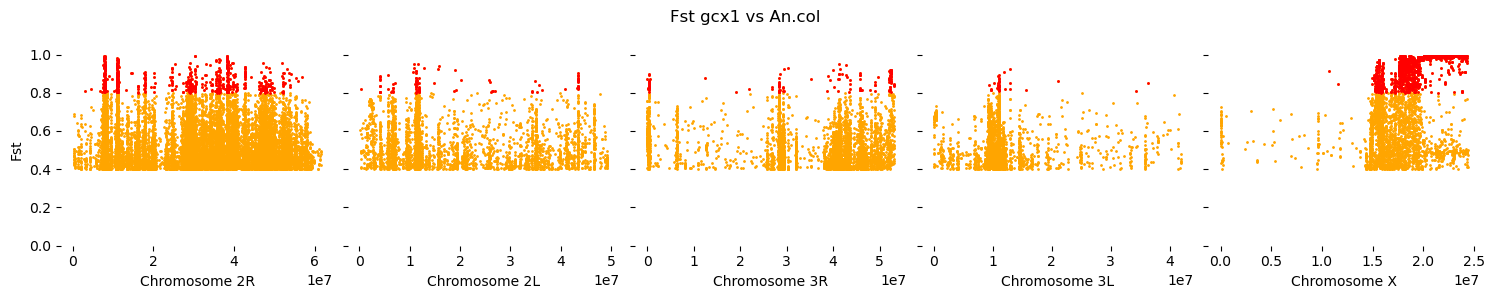

In [18]:
import matplotlib.pyplot as plt

fig, ((ax1, ax2, ax3, ax4, ax5)) = plt.subplots(1, 5, figsize=(15, 3))
fig.suptitle("Fst gcx1 vs An.col")

# Remove spines
for ax in [ax1, ax2, ax3, ax4, ax5]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

# Filtering and plotting for each subplot
for ax, data, label in zip([ax1, ax2, ax3, ax4, ax5], 
                           [a_gcx1co, b_gcx1co, c_gcx1co, d_gcx1co, e_gcx1co], 
                           ['Chromosome 2R', 'Chromosome 2L', 'Chromosome 3R', 'Chromosome 3L', 'Chromosome X']):
    filtered_indices = data[0].compute() > 0.4
    filtered_x = data[1][filtered_indices]
    filtered_y = data[0][filtered_indices]
    
    ax.plot(filtered_x, filtered_y, 'bo', markersize=1, label='> 0.4', color='orange')

    filtered_indices_09 = data[0].compute() > 0.8
    filtered_x_09 = data[1][filtered_indices_09]
    filtered_y_09 = data[0][filtered_indices_09]

    ax.plot(filtered_x_09, filtered_y_09, 'bo', markersize=1, label='> 0.8', color='red')
    
    ax.set_xlabel(label)
    ax.set_ylabel("Fst")
    ax.set_ylim(0, 1)

for ax in fig.get_axes():
    ax.label_outer()

plt.tight_layout()
plt.show()


-----------------------
## Trovare intersezione degli snps

In [1]:
import numpy as np
import dask.array as da
import allel

variables = ['a', 'b', 'c', 'd', 'e']
gcx1ga_arrays = {}
gcx1co_arrays = {}

for variable in variables:
    with np.load(f'{variable}_gcx1ga.npz') as data:
        gcx1ga_arrays[variable + '_gcx1ga'] = da.from_array(data['data'])
    with np.load(f'{variable}_gcx1co.npz') as data:
        gcx1co_arrays[variable + '_gcx1co'] = da.from_array(data['data'])

# Initialize empty lists to store common positions for each variable
common_positions = []

# Iterate over variables
for variable in variables:
    # Create SortedIndex objects
    pos1 = allel.SortedIndex(gcx1co_arrays[variable + "_gcx1co"][1])
    pos2 = allel.SortedIndex(gcx1ga_arrays[variable + "_gcx1ga"][1])
    
    # Find common positions
    loc = pos1.locate_intersection(pos2)
    
    # Append common positions to the list
    common_positions.append(loc)

# Iterate over variables and subset arrays
for i, variable in enumerate(variables):
    loc = common_positions[i]
    gcx1co_arrays[variable + "_gcx1co"] = gcx1co_arrays[variable + "_gcx1co"][:, loc[0]].compute()
    gcx1ga_arrays[variable + "_gcx1ga"] = gcx1ga_arrays[variable + "_gcx1ga"][:, loc[1]].compute()


## Find Valori

Per trovare le altezze sopra una certa soglia in entrambe ga e co

In [15]:
# Find indices where values up to 0.4 are shared between the two arrays
indices_shared = np.where((gcx1co_arrays['a_gcx1co'][0] >= 0.8) & (gcx1ga_arrays['a_gcx1ga'][0] >= 0.8) &
                          (gcx1co_arrays['a_gcx1co'][1] == gcx1ga_arrays['a_gcx1ga'][1]))

# Extract the shared values from both arrays using the shared indices
values_co_shared = gcx1co_arrays['a_gcx1co'][0][indices_shared]
values_ga_shared = gcx1ga_arrays['a_gcx1ga'][0][indices_shared]

print("Values up to 0.4 shared between gcx1co_arrays['a_gcx1co'][0] and gcx1ga_arrays['a_gcx1ga'][0]:", len(values_co_shared))
print("gcx1co_arrays['a_gcx1co'][0]:", values_co_shared)
print("gcx1ga_arrays['a_gcx1ga'][0]:", values_ga_shared)


Values up to 0.4 shared between gcx1co_arrays['a_gcx1co'][0] and gcx1ga_arrays['a_gcx1ga'][0]: 23
gcx1co_arrays['a_gcx1co'][0]: [0.88810198 0.9680584  0.84813939 0.95044127 0.83604435 0.81620049
 0.84978512 0.82882752 0.86185407 0.84435168 0.81415111 0.81655222
 0.81193098 0.82425669 0.82733931 0.82733931 0.82733931 0.81193098
 0.80731085 0.85402809 0.81039082 0.8074489  0.86555217]
gcx1ga_arrays['a_gcx1ga'][0]: [0.87534599 0.89256424 0.81503003 0.9004028  0.81938107 0.90797265
 0.89137969 0.84822153 0.96613021 0.9058767  0.91899076 0.92027966
 0.82765758 0.92027966 0.92027966 0.81354182 0.92027966 0.92027966
 0.92027966 0.90062831 0.92027966 0.91816947 0.95765921]


--------------
## Find Posizioni

In [6]:
variables = ['a_', 'b_', 'c_', 'd_','e_']

In [7]:
# Define the variables
position_6 = {}
# Iterate over the variables
for variable in variables:
    # Construct the keys for accessing the arrays
    key_co = variable + 'gcx1co'
    key_ga = variable + 'gcx1ga'
    
    # Find indices where values up to 0.8 are shared between the two arrays
    indices_shared = np.where((gcx1co_arrays[key_co][0] >= 0.6) & (gcx1ga_arrays[key_ga][0] >= 0.6) &
                              (gcx1co_arrays[key_co][1] == gcx1ga_arrays[key_ga][1]))
    
    # Extract the shared values from both arrays using the shared indices
    position_6[variable] = gcx1co_arrays[key_co][1][indices_shared]
    
    # Print or use the shared values
   # print(f"Shared values for {variable}: {position}")


In [8]:
total_elements = sum(len(arr) for arr in position_6.values())
total_elements 

733

In [22]:
# Define the variables
variables = ['a_', 'b_', 'c_', 'd_','e_']
position_8 = {}
value_8 = {}
# Iterate over the variables
for variable in variables:
    # Construct the keys for accessing the arrays
    key_co = variable + 'gcx1co'
    key_ga = variable + 'gcx1ga'
    
    # Find indices where values up to 0.8 are shared between the two arrays
    indices_shared = np.where((gcx1co_arrays[key_co][0] >= 0.9) & (gcx1ga_arrays[key_ga][0] >= 0.9) &
                              (gcx1co_arrays[key_co][1] == gcx1ga_arrays[key_ga][1]))
    
    # Extract the shared values from both arrays using the shared indices
    position_8[variable] = gcx1co_arrays[key_co][1][indices_shared]
    value_8[variable] = gcx1co_arrays[key_co][0][indices_shared]
    # Print or use the shared values
    #print(f"Shared values for {variable}: {position}")


In [23]:
total_elements = sum(len(arr) for arr in position_8.values())
total_elements 

2

In [24]:
position_8

{'a_': array([33016926.]),
 'b_': array([15855042.]),
 'c_': array([], dtype=float64),
 'd_': array([], dtype=float64),
 'e_': array([], dtype=float64)}

In [25]:
value_8

{'a_': array([0.95044127]),
 'b_': array([0.94166737]),
 'c_': array([], dtype=float64),
 'd_': array([], dtype=float64),
 'e_': array([], dtype=float64)}

## Fst 100 Kbp

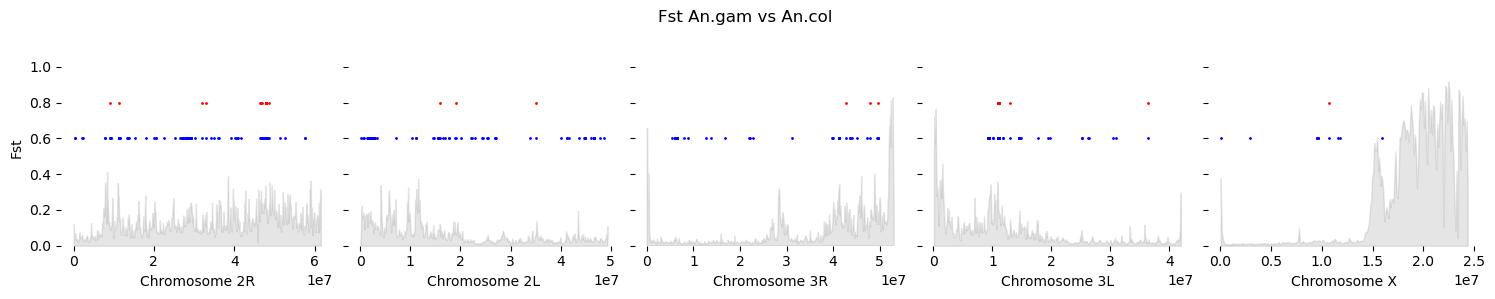

In [23]:
import matplotlib.pyplot as plt

fig, ((ax1, ax2, ax3, ax4, ax5)) = plt.subplots(1, 5, figsize=(15, 3))
fig.suptitle("Fst An.gam vs An.col")

# Remove spines
for ax in [ax1, ax2, ax3, ax4, ax5]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

#ax1.plot(a_gcx1co_100[1], a_gcx1co_100[0], lw=0.8)
ax1.fill_between(a_coga[1], 0, a_coga[0], color='grey', alpha=0.2)  # Add fill_between
ax1.plot(position_6['a_'],np.full(315,0.6), 'bo', markersize=1)
ax1.plot(position_8['a_'],np.full(len(position_8['a_']),0.8), 'or', markersize=1)

ax1.set_ylabel("Fst")
ax1.set_xlabel('Chromosome 2R')
ax1.set_ylim(0, 1.1)

#ax2.plot(b_gcx1co_100[1], b_gcx1co_100[0], lw=0.8)
ax2.fill_between(b_coga[1], 0, b_coga[0], color='grey', alpha=0.2)  # Add fill_between
ax2.plot(position_6['b_'], np.full(158,0.6), 'bo', markersize=1)
ax2.plot(position_8['b_'],np.full(len(position_8['b_']),0.8), 'or', markersize=1)

ax2.set_xlabel('Chromosome 2L')
ax2.set_ylim(0, 1.1)

#ax3.plot(c_gcx1co_100[1], c_gcx1co_100[0], lw=0.8)
ax3.fill_between(c_coga[1], 0, c_coga[0], color='grey', alpha=0.2)  # Add fill_between
ax3.plot(position_6['c_'], np.full(50,0.6), 'bo', markersize=1)
ax3.plot(position_8['c_'],np.full(len(position_8['c_']),0.8), 'or', markersize=1)
ax3.set_xlabel('Chromosome 3R')
ax3.set_ylim(0, 1.1)

#ax4.plot(d_gcx1co_100[1], d_gcx1co_100[0], lw=0.8)
ax4.fill_between(d_coga[1], 0, d_coga[0], color='grey', alpha=0.2)  # Add fill_between
ax4.plot(position_6['d_'], np.full(198,0.6), 'bo', markersize=1)
ax4.plot(position_8['d_'],np.full(len(position_8['d_']),0.8), 'or', markersize=1)
ax4.set_xlabel('Chromosome 3L')
ax4.set_ylim(0, 1.1)

#ax5.plot(e_gcx1co_100[1], e_gcx1co_100[0], lw=0.8)
ax5.fill_between(e_coga[1], 0, e_coga[0], color='grey', alpha=0.2)  # Add fill_between
ax5.plot(position_6['e_'], np.full(12, 0.6), 'bo', markersize=1)
ax5.plot(position_8['e_'],np.full(len(position_8['e_']),0.8), 'or', markersize=1)
ax5.set_xlabel('Chromosome X')
ax5.set_ylim(0, 1.1)

for ax in fig.get_axes():
    ax.label_outer()

plt.tight_layout()
plt.show()


### Fst 1bp

In [ ]:
#a_coga = plot_pair_fst('An.col', 'An.gam', '2R', start=1, stop=None, size=1)
#np.savez('a_coga.npz', data=a_coga)
#b_coga = plot_pair_fst('An.col', 'An.gam', '2L', start=1, stop=None, size=1)
#np.savez('b_coga.npz', data=b_coga)
#c_coga = plot_pair_fst('An.col', 'An.gam', '3R', start=1, stop=None, size=1)
#np.savez('c_coga.npz', data=c_coga)
#d_coga = plot_pair_fst('An.col', 'An.gam', '3L', start=1, stop=None, size=1)
#np.savez('d_coga.npz', data=d_coga)
#e_coga = plot_pair_fst('An.col', 'An.gam', 'X', start=1, stop=None, size=1)
#np.savez('e_coga.npz', data=e_coga)

variables = ['a', 'b', 'c', 'd', 'e']
coga_arrays = {}

for variable in variables:
    with np.load(f'{variable}_coga.npz') as data:
        coga_arrays[variable + '_coga'] = da.from_array(data['data'])

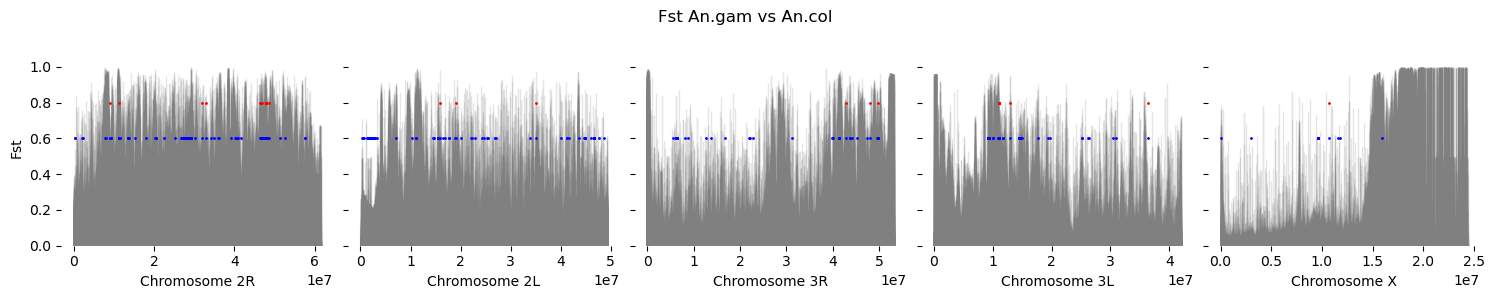

In [10]:
import matplotlib.pyplot as plt

fig, ((ax1, ax2, ax3, ax4, ax5)) = plt.subplots(1, 5, figsize=(15, 3))
fig.suptitle("Fst An.gam vs An.col")

# Remove spines
for ax in [ax1, ax2, ax3, ax4, ax5]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

#ax1.plot(a_gcx1co_100[1], a_gcx1co_100[0], lw=0.8)
ax1.fill_between(coga_arrays['a_coga'][1], 0, coga_arrays['a_coga'][0], color='grey', alpha=0.2)  # Add fill_between
ax1.plot(position_6['a_'],np.full(315,0.6), 'bo', markersize=1)
ax1.plot(position_8['a_'],np.full(len(position_8['a_']),0.8), 'or', markersize=1)

ax1.set_ylabel("Fst")
ax1.set_xlabel('Chromosome 2R')
ax1.set_ylim(0, 1.1)

#ax2.plot(b_gcx1co_100[1], b_gcx1co_100[0], lw=0.8)
ax2.fill_between(coga_arrays['b_coga'][1], 0, coga_arrays['b_coga'][0], color='grey', alpha=0.2)  # Add fill_between
ax2.plot(position_6['b_'], np.full(158,0.6), 'bo', markersize=1)
ax2.plot(position_8['b_'],np.full(len(position_8['b_']),0.8), 'or', markersize=1)

ax2.set_xlabel('Chromosome 2L')
ax2.set_ylim(0, 1.1)

#ax3.plot(c_gcx1co_100[1], c_gcx1co_100[0], lw=0.8)
ax3.fill_between(coga_arrays['c_coga'][1], 0, coga_arrays['c_coga'][0], color='grey', alpha=0.2)  # Add fill_between
ax3.plot(position_6['c_'], np.full(50,0.6), 'bo', markersize=1)
ax3.plot(position_8['c_'],np.full(len(position_8['c_']),0.8), 'or', markersize=1)
ax3.set_xlabel('Chromosome 3R')
ax3.set_ylim(0, 1.1)

#ax4.plot(d_gcx1co_100[1], d_gcx1co_100[0], lw=0.8)
ax4.fill_between(coga_arrays['d_coga'][1], 0, coga_arrays['d_coga'][0], color='grey', alpha=0.2)  # Add fill_between
ax4.plot(position_6['d_'], np.full(198,0.6), 'bo', markersize=1)
ax4.plot(position_8['d_'],np.full(len(position_8['d_']),0.8), 'or', markersize=1)
ax4.set_xlabel('Chromosome 3L')
ax4.set_ylim(0, 1.1)

#ax5.plot(e_gcx1co_100[1], e_gcx1co_100[0], lw=0.8)
ax5.fill_between(coga_arrays['e_coga'][1], 0, coga_arrays['e_coga'][0], color='grey', alpha=0.2)  # Add fill_between
ax5.plot(position_6['e_'], np.full(12, 0.6), 'bo', markersize=1)
ax5.plot(position_8['e_'],np.full(len(position_8['e_']),0.8), 'or', markersize=1)
ax5.set_xlabel('Chromosome X')
ax5.set_ylim(0, 1.1)

for ax in fig.get_axes():
    ax.label_outer()

plt.tight_layout()
plt.show()


----------------
## Sandbox

In [5]:
import pandas as pd
fst_snps = pd.read_csv("/mnt/c/Users/rando/Documenti/Ag1000G/Data/fst/fst_top_values_gaco.csv", sep=";")

In [6]:
fst_snps

,Chrom,Pos,Value
0,2R,33016926,0.950441
1,2L,15855042,0.941667
2,2R,8992233,0.888102
3,2R,11242899,0.968058
4,2R,31989358,0.848139
5,2R,33016926,0.950441
6,2R,46299294,0.836044
7,2R,46687331,0.816200
8,2R,46792110,0.849785
9,2R,47795676,0.828828


In [7]:
fst_snps_2R = fst_snps[fst_snps.Chrom=="2R"]
fst_snps_2L = fst_snps[fst_snps.Chrom=="2L"]
fst_snps_3R = fst_snps[fst_snps.Chrom=="3R"]
fst_snps_3L = fst_snps[fst_snps.Chrom=="3L"]
fst_snps_X = fst_snps[fst_snps.Chrom=="X"]

In [8]:
import dask.array as da
variables = ['a', 'b', 'c', 'd', 'e']
coga_arrays = {}

for variable in variables:
    with np.load(f'Fst_1bp/coga/{variable}_coga.npz') as data:
        coga_arrays[variable + '_coga'] = da.from_array(data['data'])

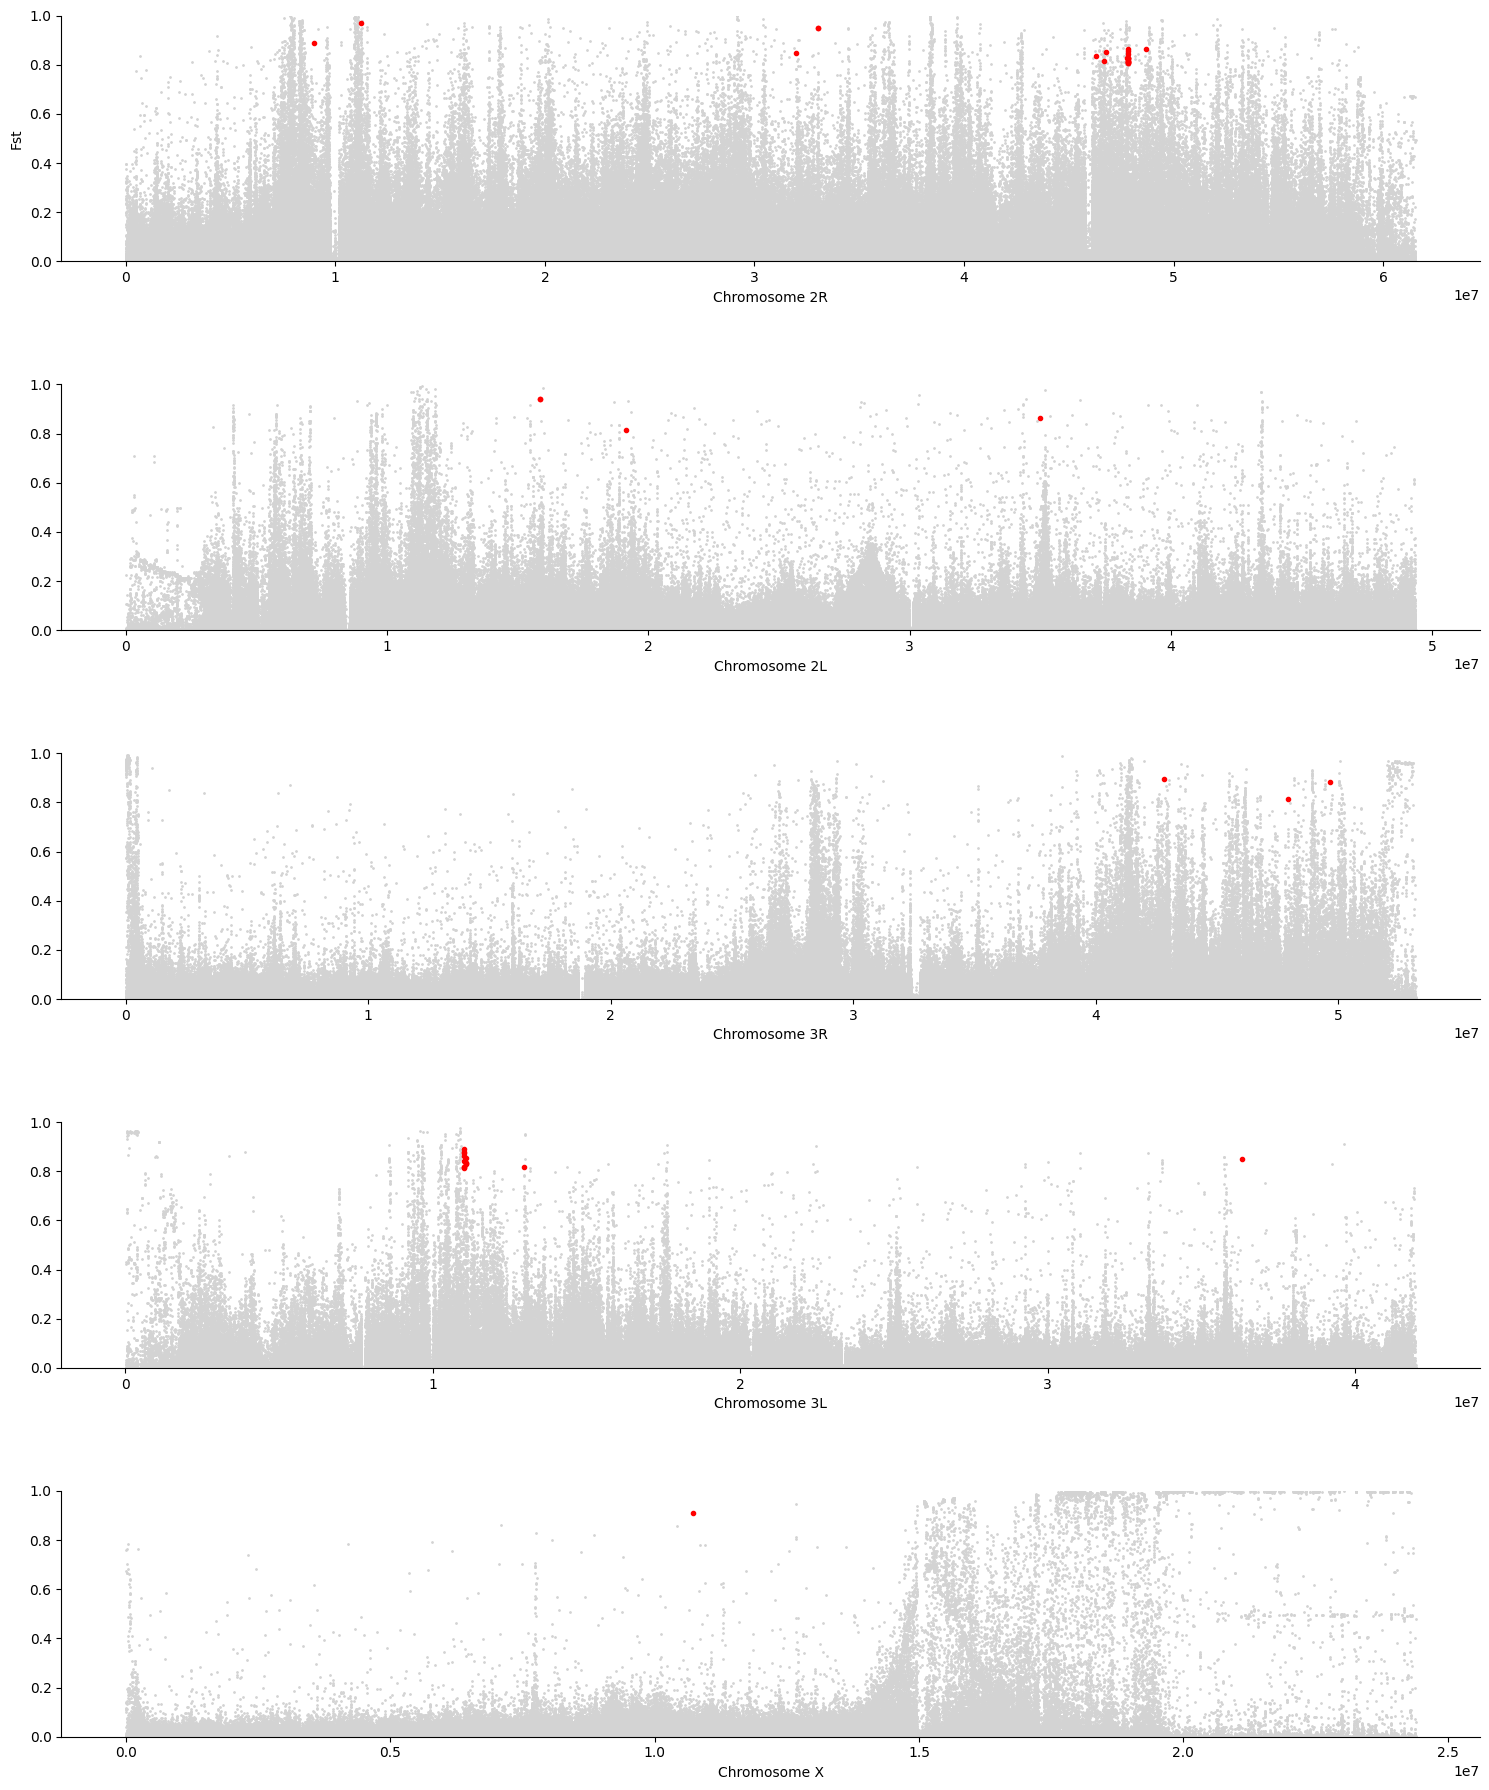

In [10]:
import matplotlib.pyplot as plt

fig, ((ax1, ax2, ax3, ax4, ax5)) = plt.subplots(5, 1, figsize=(15, 18))

#fig.suptitle("Fst An.gam vs An.col")



#ax1.plot(a_gcx1co_100[1], a_gcx1co_100[0], lw=0.8)
ax1.plot(coga_arrays["a_coga"][1], coga_arrays["a_coga"][0],'o', color='lightgray', markersize=1)  # Add fill_between
ax1.plot(fst_snps_2R.Pos,fst_snps_2R.Value, 'ro', markersize=3)

ax1.set_ylabel("Fst")
ax1.set_xlabel('Chromosome 2R')
ax1.set_ylim(0, 1)

ax2.plot(coga_arrays['b_coga'][1],  coga_arrays['b_coga'][0],'o', color='lightgray', markersize=1)  # Add fill_between
ax2.plot(fst_snps_2L.Pos,fst_snps_2L.Value, 'ro', markersize=3)

ax2.set_xlabel('Chromosome 2L')
ax2.set_ylim(0, 1)

#ax3.plot(c_gcx1co_100[1], c_gcx1co_100[0], lw=0.8)
ax3.plot(coga_arrays['c_coga'][1],  coga_arrays['c_coga'][0],'o', color='lightgray', markersize=1)  # Add fill_between
ax3.plot(fst_snps_3R.Pos,fst_snps_3R.Value, 'ro', markersize=3)
ax3.set_xlabel('Chromosome 3R')
ax3.set_ylim(0, 1)

#ax4.plot(d_gcx1co_100[1], d_gcx1co_100[0], lw=0.8)
ax4.plot(coga_arrays['d_coga'][1],  coga_arrays['d_coga'][0],'o', color='lightgray', markersize=1)  # Add fill_between
ax4.plot(fst_snps_3L.Pos,fst_snps_3L.Value, 'ro', markersize=3)
ax4.set_xlabel('Chromosome 3L')
ax4.set_ylim(0, 1)

#ax5.plot(e_gcx1co_100[1], e_gcx1co_100[0], lw=0.8)
ax5.plot(coga_arrays['e_coga'][1],  coga_arrays['e_coga'][0],'o', color='lightgray', markersize=1)  # Add fill_between
ax5.plot(fst_snps_X.Pos,fst_snps_X.Value, 'ro', markersize=3)
ax5.set_xlabel('Chromosome X')
ax5.set_ylim(0, 1)

plt.tight_layout()  # Ottimizza lo spazio tra i subplot
plt.subplots_adjust(hspace=0.5)  # Aggiungi spazio orizzontale tra i subplot
sns.despine()
plt.show()

------------------------
## Per chr

In [27]:
fst_snps_2R.Pos[9:23]

10    47804029
11    47839490
12    47839623
13    47840390
14    47842560
15    47842599
16    47842715
17    47842773
18    47842784
19    47844288
20    47844438
21    47845416
22    47845945
23    47846826
Name: Pos, dtype: int64

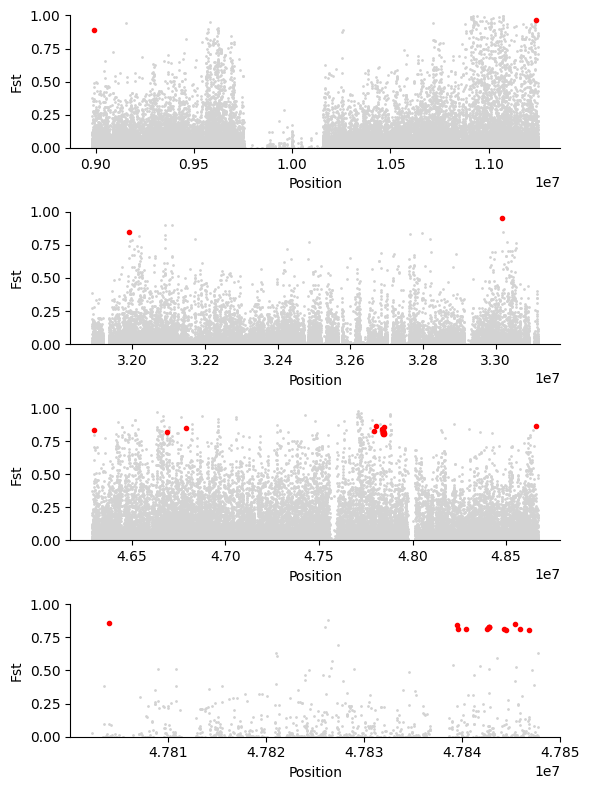

In [29]:
fig,(ax1,ax2, ax3, ax4)  = plt.subplots(4,1, figsize=(6, 8))
start_index = np.where(coga_arrays["a_coga"][1].compute() == 8982233)[0][0]
end_index = np.where(coga_arrays["a_coga"][1].compute() == 11252899)[0][0]
ax1.plot(coga_arrays["a_coga"][1][start_index:end_index].compute(), coga_arrays["a_coga"][0][start_index:end_index].compute(),'o', color='lightgray', markersize=1)  # Add fill_between
ax1.plot(fst_snps_2R.Pos[1:3],fst_snps_2R.Value[1:3], 'ro', markersize=3)
ax1.set_ylabel("Fst")
ax1.set_xlabel('Position')
ax1.set_ylim(0, 1)

start_index = np.where(coga_arrays["a_coga"][1].compute() == 31889358)[0][0]
end_index = np.where(coga_arrays["a_coga"][1].compute() == 33116926)[0][0]
ax2.plot(coga_arrays["a_coga"][1][start_index:end_index].compute(), coga_arrays["a_coga"][0][start_index:end_index].compute(),'o', color='lightgray', markersize=1)  # Add fill_between
ax2.plot(fst_snps_2R.Pos[3:5],fst_snps_2R.Value[3:5], 'ro', markersize=3)
ax2.set_ylabel("Fst")
ax2.set_xlabel('Position')
ax2.set_ylim(0, 1)

start_index = np.where(coga_arrays["a_coga"][1].compute() == 46289294)[0][0]
end_index = np.where(coga_arrays["a_coga"][1].compute() == 48671308)[0][0]
ax3.plot(coga_arrays["a_coga"][1][start_index:end_index].compute(), coga_arrays["a_coga"][0][start_index:end_index].compute(),'o', color='lightgray', markersize=1)  # Add fill_between
ax3.plot(fst_snps_2R.Pos[5:],fst_snps_2R.Value[5:], 'ro', markersize=3)
ax3.set_ylabel("Fst")
ax3.set_xlabel('Position')
ax3.set_ylim(0, 1)

start_index = np.where(coga_arrays["a_coga"][1].compute() == 47802029)[0][0]
end_index = np.where(coga_arrays["a_coga"][1].compute() == 47847826)[0][0]
ax4.plot(coga_arrays["a_coga"][1][start_index:end_index].compute(), coga_arrays["a_coga"][0][start_index:end_index].compute(),'o', color='lightgray', markersize=1)  # Add fill_between
ax4.plot(fst_snps_2R.Pos[9:23],fst_snps_2R.Value[9:23], 'ro', markersize=3)
ax4.set_ylabel("Fst")
ax4.set_xlabel('Position')
ax4.set_ylim(0, 1)

fig.tight_layout()
sns.despine()

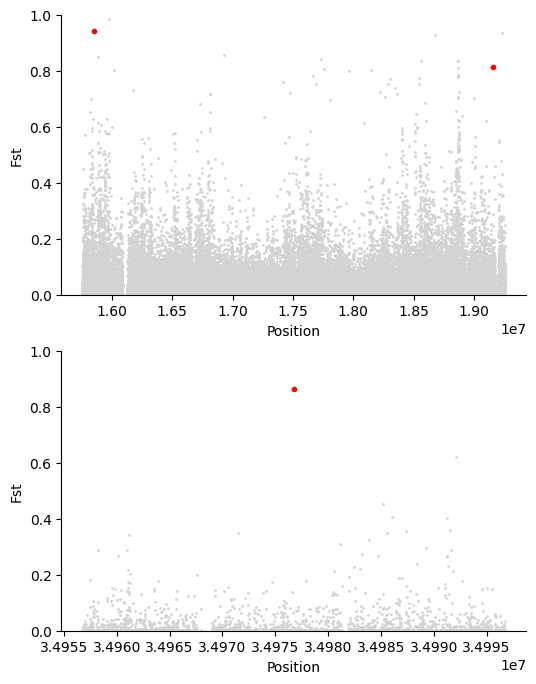

In [30]:

fig,(ax1,ax2)  = plt.subplots(2,1, figsize=(6, 8))
start_index = np.where(coga_arrays["b_coga"][1].compute() == 15755042)[0][0]
end_index = np.where(coga_arrays["b_coga"][1].compute() == 19258637)[0][0]
ax1.plot(coga_arrays["b_coga"][1][start_index:end_index].compute(), coga_arrays["b_coga"][0][start_index:end_index].compute(),'o', color='lightgray', markersize=1)  # Add fill_between
ax1.plot(fst_snps_2L.Pos[1],fst_snps_2L.Value[1], 'ro', markersize=3)
ax1.plot(fst_snps_2L.Pos[26],fst_snps_2L.Value[26], 'ro', markersize=3)
ax1.set_ylabel("Fst")
ax1.set_xlabel('Position')
ax1.set_ylim(0, 1)

start_index = np.where(coga_arrays["b_coga"][1].compute() == 34956756)[0][0]
end_index = np.where(coga_arrays["b_coga"][1].compute() == 34996756)[0][0]
ax2.plot(coga_arrays["b_coga"][1][start_index:end_index].compute(), coga_arrays["b_coga"][0][start_index:end_index].compute(),'o', color='lightgray', markersize=1)  # Add fill_between
ax2.plot(fst_snps_2L.Pos[27],fst_snps_2L.Value[27], 'ro', markersize=3)
ax2.set_ylabel("Fst")
ax2.set_xlabel('Position')
ax2.set_ylim(0, 1)
sns.despine()

In [53]:
fst_snps_3R

,Chrom,Pos,Value
28,3R,42825312,0.893657
29,3R,47934132,0.812515
30,3R,49674977,0.884312


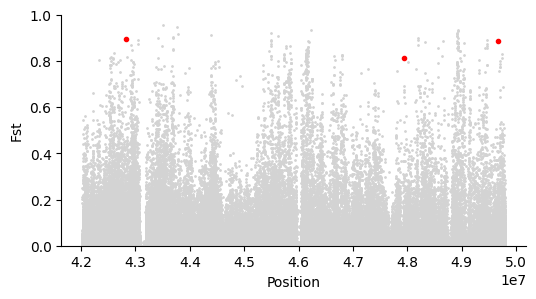

In [33]:
fig,ax1  = plt.subplots(figsize=(6, 3))
start_index = np.where(coga_arrays["c_coga"][1].compute() == 42025312)[0][0]
end_index = np.where(coga_arrays["c_coga"][1].compute() == 49_800_000)[0][0]
ax1.plot(coga_arrays["c_coga"][1][start_index:end_index].compute(), coga_arrays["c_coga"][0][start_index:end_index].compute(),'o', color='lightgray', markersize=1)  # Add fill_between
ax1.plot(fst_snps.Pos[28:31],fst_snps.Value[28:31], 'ro', markersize=3)
ax1.set_ylabel("Fst")
ax1.set_xlabel('Position')
ax1.set_ylim(0, 1)
sns.despine()

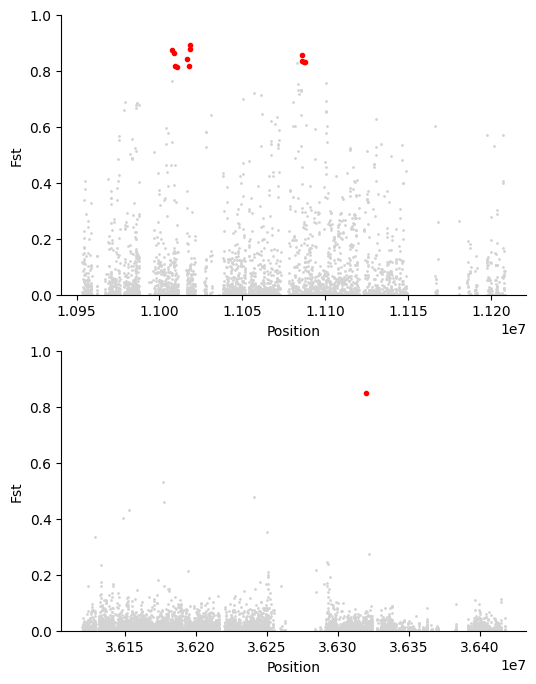

In [40]:
fig,(ax1,ax2)  = plt.subplots(2,1, figsize=(6, 8))
start_index = np.where(coga_arrays["d_coga"][1].compute() == 10_953_513)[0][0]
end_index = np.where(coga_arrays["d_coga"][1].compute() == 11_211_713)[0][0]
ax1.plot(coga_arrays["d_coga"][1][start_index:end_index].compute(), coga_arrays["d_coga"][0][start_index:end_index].compute(),'o', color='lightgray', markersize=1)  # Add fill_between
ax1.plot(fst_snps.Pos[31:43],fst_snps.Value[31:43], 'ro', markersize=3)
ax1.set_ylabel("Fst")
ax1.set_xlabel('Position')
ax1.set_ylim(0, 1)

start_index = np.where(coga_arrays["d_coga"][1].compute() == 36119905)[0][0]
end_index = np.where(coga_arrays["d_coga"][1].compute() == 36419905)[0][0]
ax2.plot(coga_arrays["d_coga"][1][start_index:end_index].compute(), coga_arrays["d_coga"][0][start_index:end_index].compute(),'o', color='lightgray', markersize=1)  # Add fill_between
ax2.plot(fst_snps.Pos[44],fst_snps.Value[44], 'ro', markersize=3)
ax2.set_ylabel("Fst")
ax2.set_xlabel('Position')
ax2.set_ylim(0, 1)

sns.despine()

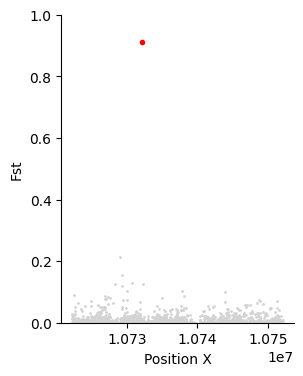

In [70]:
fig,ax1  = plt.subplots(figsize=(3, 4))
start_index = np.where(coga_arrays["e_coga"][1].compute() == 10_722_185)[0][0]
end_index = np.where(coga_arrays["e_coga"][1].compute() == 10_752_185)[0][0]
ax1.plot(coga_arrays["e_coga"][1][start_index:end_index].compute(), coga_arrays["e_coga"][0][start_index:end_index].compute(),'o', color='lightgray', markersize=1)  # Add fill_between
ax1.plot(fst_snps.Pos[45],fst_snps.Value[45], 'ro', markersize=3)
ax1.set_ylabel("Fst")
ax1.set_xlabel('Position X')
ax1.set_ylim(0, 1)
sns.despine()

In [24]:
47_838_000
47_847_000

array([-0.00097582,         nan,         nan, ...,         nan,
               nan,  0.49410215])

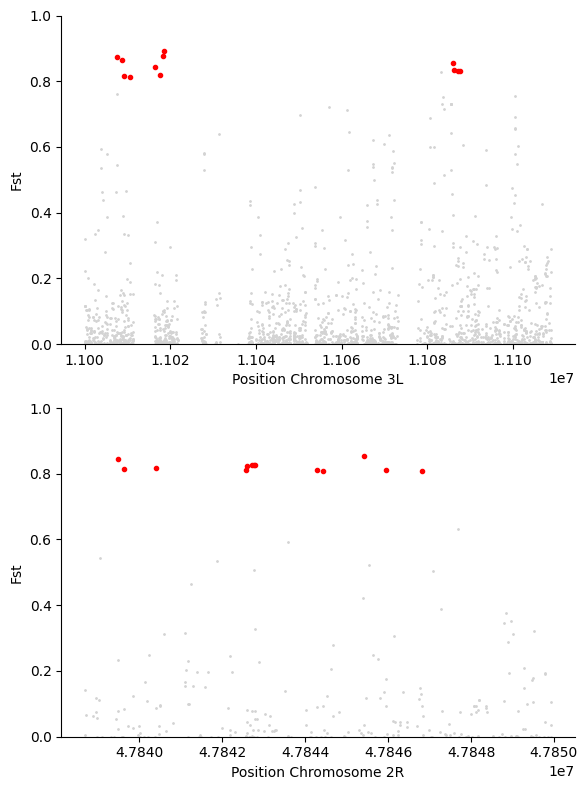

In [28]:
fig,(ax1,ax2)  = plt.subplots(2,1, figsize=(6, 8))
start_index = np.where(coga_arrays["d_coga"][1].compute() == 11_000_000)[0][0]
end_index = np.where(coga_arrays["d_coga"][1].compute() == 11_109_000)[0][0]
ax1.plot(coga_arrays["d_coga"][1][start_index:end_index].compute(), coga_arrays["d_coga"][0][start_index:end_index].compute(),'o', color='lightgray', markersize=1)  # Add fill_between
ax1.plot(fst_snps.Pos[31:43],fst_snps.Value[31:43], 'ro', markersize=3)
ax1.set_ylabel("Fst")
ax1.set_xlabel('Position Chromosome 3L')
ax1.set_ylim(0, 1)

start_index = np.where(coga_arrays["a_coga"][1].compute() == 47_838_000)[0][0]
end_index = np.where(coga_arrays["a_coga"][1].compute() == 47_850_000)[0][0]
ax2.plot(coga_arrays["a_coga"][1][start_index:end_index].compute(), coga_arrays["a_coga"][0][start_index:end_index].compute(),'o', color='lightgray', markersize=1)  # Add fill_between
ax2.plot(fst_snps_2R.Pos[10:23],fst_snps_2R.Value[10:23], 'ro', markersize=3)
ax2.set_ylabel("Fst")
ax2.set_xlabel('Position Chromosome 2R')
ax2.set_ylim(0, 1)

fig.tight_layout()
sns.despine()

-------------------------

## gcx1-gw

In [12]:
a_gcx1gwga = plot_pair_fst('GW', 'An.gam', '2R', start=1, stop=None, size=1)
b_gcx1gwga = plot_pair_fst('GW', 'An.gam', '2L', start=1, stop=None, size=1)
c_gcx1gwga = plot_pair_fst('GW', 'An.gam', '3R', start=1, stop=None, size=1)
d_gcx1gwga = plot_pair_fst('GW', 'An.gam', '3L', start=1, stop=None, size=1)
e_gcx1gwga = plot_pair_fst('GW', 'An.gam', 'X', start=1, stop=None, size=1)
np.savez('a_gcx1gwga.npz', data=a_gcx1gwga)
np.savez('b_gcx1gwga.npz', data=b_gcx1gwga)
np.savez('c_gcx1gwga.npz', data=c_gcx1gwga)
np.savez('d_gcx1gwga.npz', data=d_gcx1gwga)
np.savez('e_gcx1gwga.npz', data=e_gcx1gwga)

ascertainment GW An.gam 2R 1 None 1466391
ascertainment GW An.gam 2L 1 None 1610390
ascertainment GW An.gam 3R 1 None 1991186
ascertainment GW An.gam 3L 1 None 1446109
ascertainment GW An.gam X 1 None 631093


In [13]:
a_gcx1gwco = plot_pair_fst('GW', 'An.col', '2R', start=1, stop=None, size=1)
b_gcx1gwco = plot_pair_fst('GW', 'An.col', '2L', start=1, stop=None, size=1)
c_gcx1gwco = plot_pair_fst('GW', 'An.col', '3R', start=1, stop=None, size=1)
d_gcx1gwco = plot_pair_fst('GW', 'An.col', '3L', start=1, stop=None, size=1)
e_gcx1gwco = plot_pair_fst('GW', 'An.col', 'X', start=1, stop=None, size=1)
np.savez('a_gcx1gwco.npz', data=a_gcx1gwco)
np.savez('b_gcx1gwco.npz', data=b_gcx1gwco)
np.savez('c_gcx1gwco.npz', data=c_gcx1gwco)
np.savez('d_gcx1gwco.npz', data=d_gcx1gwco)
np.savez('e_gcx1gwco.npz', data=e_gcx1gwco)

ascertainment GW An.col 2R 1 None 1279648
ascertainment GW An.col 2L 1 None 1555148
ascertainment GW An.col 3R 1 None 1954081
ascertainment GW An.col 3L 1 None 1410230
ascertainment GW An.col X 1 None 590799


In [1]:
import numpy as np
import dask.array as da
import allel

variables = ['a', 'b', 'c', 'd', 'e']
gcx1ga_arrays = {}
gcx1co_arrays = {}

for variable in variables:
    with np.load(f'{variable}_gcx1ga.npz') as data:
        gcx1ga_arrays[variable + '_gcx1gwga'] = da.from_array(data['data'])
    with np.load(f'{variable}_gcx1co.npz') as data:
        gcx1co_arrays[variable + '_gcx1gwco'] = da.from_array(data['data'])

# Initialize empty lists to store common positions for each variable
common_positions = []

# Iterate over variables
for variable in variables:
    # Create SortedIndex objects
    pos1 = allel.SortedIndex(gcx1co_arrays[variable + "_gcx1gwco"][1])
    pos2 = allel.SortedIndex(gcx1ga_arrays[variable + "_gcx1gwga"][1])
    
    # Find common positions
    loc = pos1.locate_intersection(pos2)
    
    # Append common positions to the list
    common_positions.append(loc)

# Iterate over variables and subset arrays
for i, variable in enumerate(variables):
    loc = common_positions[i]
    gcx1co_arrays[variable + "_gcx1gwco"] = gcx1co_arrays[variable + "_gcx1gwco"][:, loc[0]].compute()
    gcx1ga_arrays[variable + "_gcx1gwga"] = gcx1ga_arrays[variable + "_gcx1gwga"][:, loc[1]].compute()


In [2]:
gcx1ga_arrays

{'a_gcx1gwga': array([[          nan,           nan,           nan, ...,           nan,
                   nan,           nan],
        [1.3930000e+03, 1.3940000e+03, 1.3950000e+03, ..., 6.1542360e+07,
         6.1542361e+07, 6.1542362e+07]]),
 'b_gcx1gwga': array([[7.87928196e-03,            nan,            nan, ...,
                    nan,            nan,            nan],
        [6.14400000e+03, 6.14500000e+03, 6.14600000e+03, ...,
         4.93555960e+07, 4.93555970e+07, 4.93555980e+07]]),
 'c_gcx1gwga': array([[1.94748515e-03,            nan,            nan, ...,
                    nan,            nan,            nan],
        [3.72000000e+02, 3.73000000e+02, 3.74000000e+02, ...,
         5.31950660e+07, 5.31950670e+07, 5.31950680e+07]]),
 'd_gcx1gwga': array([[3.88398171e-03,            nan,            nan, ...,
                    nan,            nan, 4.26974695e-02],
        [2.04420000e+04, 2.04430000e+04, 2.04440000e+04, ...,
         4.19626320e+07, 4.19626330e+07, 4.19626

In [3]:
variables = ['a_', 'b_', 'c_', 'd_','e_']
position_8 = {}
value_8 = {}
# Iterate over the variables
for variable in variables:
    # Construct the keys for accessing the arrays
    key_co = variable + 'gcx1gwco'
    key_ga = variable + 'gcx1gwga'
    
    # Find indices where values up to 0.8 are shared between the two arrays
    indices_shared = np.where((gcx1co_arrays[key_co][0] >= 0.8) & (gcx1ga_arrays[key_ga][0] >= 0.8) &
                              (gcx1co_arrays[key_co][1] == gcx1ga_arrays[key_ga][1]))
    
    # Extract the shared values from both arrays using the shared indices
    position_8[variable] = gcx1co_arrays[key_co][1][indices_shared]
    value_8[variable] = gcx1co_arrays[key_co][0][indices_shared]
    # Print or use the shared values
    #print(f"Shared values for {variable}: {position}")


In [4]:
position_8

{'a_': array([ 8992233., 11242899., 31989358., 33016926., 46299294., 46687331.,
        46792110., 47795676., 47804029., 47839490., 47839623., 47840390.,
        47842560., 47842599., 47842715., 47842773., 47842784., 47844288.,
        47844438., 47845416., 47845945., 47846826., 48661308.]),
 'b_': array([15855042., 19158637., 34976756.]),
 'c_': array([42825312., 47934132., 49674977.]),
 'd_': array([11007513., 11008629., 11009221., 11010625., 11016526., 11017652.,
        11018270., 11018602., 11086132., 11086226., 11087198., 11087632.,
        12955662., 36319905.]),
 'e_': array([10732185.])}

In [5]:
value_8

{'a_': array([0.88810198, 0.9680584 , 0.84813939, 0.95044127, 0.83604435,
        0.81620049, 0.84978512, 0.82882752, 0.86185407, 0.84435168,
        0.81415111, 0.81655222, 0.81193098, 0.82425669, 0.82733931,
        0.82733931, 0.82733931, 0.81193098, 0.80731085, 0.85402809,
        0.81039082, 0.8074489 , 0.86555217]),
 'b_': array([0.94166737, 0.81306535, 0.86281526]),
 'c_': array([0.89365741, 0.81251512, 0.88431237]),
 'd_': array([0.87375861, 0.86310995, 0.81574796, 0.81158217, 0.84214489,
        0.81842554, 0.87687004, 0.89217743, 0.85518367, 0.83374483,
        0.83016358, 0.83179114, 0.81886957, 0.84870849]),
 'e_': array([0.91154162])}

## gcx2

In [11]:
a_gcx2ga = plot_pair_fst('GM-1', 'An.gam', '2R', start=1, stop=None, size=1)
b_gcx2ga = plot_pair_fst('GM-1', 'An.gam', '2L', start=1, stop=None, size=1)
c_gcx2ga = plot_pair_fst('GM-1', 'An.gam', '3R', start=1, stop=None, size=1)
d_gcx2ga = plot_pair_fst('GM-1', 'An.gam', '3L', start=1, stop=None, size=1)
e_gcx2ga = plot_pair_fst('GM-1', 'An.gam', 'X', start=1, stop=None, size=1)
np.savez('a_gcx2ga.npz', data=a_gcx2ga)
np.savez('b_gcx2ga.npz', data=b_gcx2ga)
np.savez('c_gcx2ga.npz', data=c_gcx2ga)
np.savez('d_gcx2ga.npz', data=d_gcx2ga)
np.savez('e_gcx2ga.npz', data=e_gcx2ga)

ascertainment GM-1 An.gam 2R 1 None 1672663
ascertainment GM-1 An.gam 2L 1 None 1898319
ascertainment GM-1 An.gam 3R 1 None 2280738
ascertainment GM-1 An.gam 3L 1 None 1654793
ascertainment GM-1 An.gam X 1 None 724279


In [12]:
a_gcx2co = plot_pair_fst('GM-1', 'An.col', '2R', start=1, stop=None, size=1)
b_gcx2co = plot_pair_fst('GM-1', 'An.col', '2L', start=1, stop=None, size=1)
c_gcx2co = plot_pair_fst('GM-1', 'An.col', '3R', start=1, stop=None, size=1)
d_gcx2co = plot_pair_fst('GM-1', 'An.col', '3L', start=1, stop=None, size=1)
e_gcx2co = plot_pair_fst('GM-1', 'An.col', 'X', start=1, stop=None, size=1)
np.savez('a_gcx2co.npz', data=a_gcx2co)
np.savez('b_gcx2co.npz', data=b_gcx2co)
np.savez('c_gcx2co.npz', data=c_gcx2co)
np.savez('d_gcx2co.npz', data=d_gcx2co)
np.savez('e_gcx2co.npz', data=e_gcx2co)

ascertainment GM-1 An.col 2R 1 None 2060958
ascertainment GM-1 An.col 2L 1 None 2315416
ascertainment GM-1 An.col 3R 1 None 2598472
ascertainment GM-1 An.col 3L 1 None 1866811
ascertainment GM-1 An.col X 1 None 800732


In [2]:
import numpy as np
import dask.array as da
import allel

variables = ['a', 'b', 'c', 'd', 'e']
gcx1ga_arrays = {}
gcx1co_arrays = {}

for variable in variables:
    with np.load(f'{variable}_gcx1ga.npz') as data:
        gcx1ga_arrays[variable + '_gcx2ga'] = da.from_array(data['data'])
    with np.load(f'{variable}_gcx1co.npz') as data:
        gcx1co_arrays[variable + '_gcx2co'] = da.from_array(data['data'])

# Initialize empty lists to store common positions for each variable
common_positions = []

# Iterate over variables
for variable in variables:
    # Create SortedIndex objects
    pos1 = allel.SortedIndex(gcx1co_arrays[variable + "_gcx2co"][1])
    pos2 = allel.SortedIndex(gcx1ga_arrays[variable + "_gcx2ga"][1])
    
    # Find common positions
    loc = pos1.locate_intersection(pos2)
    
    # Append common positions to the list
    common_positions.append(loc)

# Iterate over variables and subset arrays
for i, variable in enumerate(variables):
    loc = common_positions[i]
    gcx1co_arrays[variable + "_gcx2co"] = gcx1co_arrays[variable + "_gcx2co"][:, loc[0]].compute()
    gcx1ga_arrays[variable + "_gcx2ga"] = gcx1ga_arrays[variable + "_gcx2ga"][:, loc[1]].compute()


In [3]:
variables = ['a_', 'b_', 'c_', 'd_','e_']
position_8 = {}
value_8 = {}
# Iterate over the variables
for variable in variables:
    # Construct the keys for accessing the arrays
    key_co = variable + 'gcx2co'
    key_ga = variable + 'gcx2ga'
    
    # Find indices where values up to 0.8 are shared between the two arrays
    indices_shared = np.where((gcx1co_arrays[key_co][0] >= 0.8) & (gcx1ga_arrays[key_ga][0] >= 0.8) &
                              (gcx1co_arrays[key_co][1] == gcx1ga_arrays[key_ga][1]))
    
    # Extract the shared values from both arrays using the shared indices
    position_8[variable] = gcx1co_arrays[key_co][1][indices_shared]
    value_8[variable] = gcx1co_arrays[key_co][0][indices_shared]
    # Print or use the shared values
    #print(f"Shared values for {variable}: {position}")


In [4]:
position_8

{'a_': array([ 8992233., 11242899., 31989358., 33016926., 46299294., 46687331.,
        46792110., 47795676., 47804029., 47839490., 47839623., 47840390.,
        47842560., 47842599., 47842715., 47842773., 47842784., 47844288.,
        47844438., 47845416., 47845945., 47846826., 48661308.]),
 'b_': array([15855042., 19158637., 34976756.]),
 'c_': array([42825312., 47934132., 49674977.]),
 'd_': array([11007513., 11008629., 11009221., 11010625., 11016526., 11017652.,
        11018270., 11018602., 11086132., 11086226., 11087198., 11087632.,
        12955662., 36319905.]),
 'e_': array([10732185.])}

In [5]:
value_8

{'a_': array([0.88810198, 0.9680584 , 0.84813939, 0.95044127, 0.83604435,
        0.81620049, 0.84978512, 0.82882752, 0.86185407, 0.84435168,
        0.81415111, 0.81655222, 0.81193098, 0.82425669, 0.82733931,
        0.82733931, 0.82733931, 0.81193098, 0.80731085, 0.85402809,
        0.81039082, 0.8074489 , 0.86555217]),
 'b_': array([0.94166737, 0.81306535, 0.86281526]),
 'c_': array([0.89365741, 0.81251512, 0.88431237]),
 'd_': array([0.87375861, 0.86310995, 0.81574796, 0.81158217, 0.84214489,
        0.81842554, 0.87687004, 0.89217743, 0.85518367, 0.83374483,
        0.83016358, 0.83179114, 0.81886957, 0.84870849]),
 'e_': array([0.91154162])}